In [36]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pylab as plot


In [4]:
#Combining test and train data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



In [5]:
 # extracting and then removing the targets from the training data 

targets = train.Survived
train.drop(['Survived'], 1, inplace=True)

In [8]:
    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)


In [9]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
print(combined.shape)

(1309, 10)


train and test sets are combined.

You may notice that the total number of rows (1309) is the exact summation of the number of rows in the train set and the test set.



Extracting the passenger titles
When looking at the passenger names one could wonder how to process them to extract a useful information.

If you look closely at these first examples:

Braund, Mr. Owen Harris
Heikkinen, Miss. Laina
Oliva y Ocana, Dona. Fermina
Peter, Master. Michael J
You will notice that each name has a title in it ! This can be a simple Miss. or Mrs. but it can be sometimes something more sophisticated like Master, Sir or Dona. In that case, we might introduce an additional information about the social status by simply parsing the name and extracting the title and converting to a binary variable.

Let's see how we'll do that in the function below.

Let's first see what the different titles are in the train set



In [11]:
titles = set()
for name in data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())


In [13]:
print(titles)


{'Mr', 'Miss', 'Sir', 'Dr', 'Don', 'Mme', 'Ms', 'Mlle', 'the Countess', 'Jonkheer', 'Lady', 'Capt', 'Master', 'Col', 'Mrs', 'Rev', 'Major'}


In [21]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Dona" : "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    #status('Title')
    return combined


This function parses the names and extract the titles. Then, it maps the titles to categories of titles. We selected :

Officer
Royalty
Mr
Mrs
Miss
Master
Let's run it !



In [22]:
combined = get_titles()


In [23]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Let's check if the titles have been filled correctly.



In [24]:
combined[combined['Title'].isnull()]


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


Processing the ages
We have seen in the first part that the Age variable was missing 177 values. This is a large number ( ~ 13% of the dataset). Simply replacing them with the mean or the median age might not be the best solution since the age may differ by groups and categories of passengers.

To understand why, let's group our dataset by sex, Title and passenger class and for each subset compute the median age.

To avoid data leakage from the test set, we fill in missing ages in the train using the train set and we fill in ages in the test set using values calculated from the train set as well.




In [27]:
#Number of missing ages in train set

print(combined.iloc[:891].Age.isnull().sum())


177


In [30]:
#Number of missing ages in test set

print(combined.iloc[891:].Age.isnull().sum())


86


In [26]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]


In [31]:
grouped_median_train.head()


,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


This dataframe will help us impute missing age values based on different criteria.

Look at the median age column and see how this value can be different based on the Sex, Pclass and Title put together.

For example:

If the passenger is female, from Pclass 1, and from royalty the median age is 40.5.
If the passenger is male, from Pclass 3, with a Mr title, the median age is 26.


In [41]:
#Let's create a function that fills in the missing age in combined based on these different attributes.

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
  #  status('age')
    return combined



In [38]:
combined = process_age()


Processing age : ok
Perfect. The missing ages have been replaced.

However, we notice a missing value in Fare, two missing values in Embarked and a lot of missing values in Cabin. We'll come back to these variables later.

Let's now process the names.



In [43]:
def process_names():
    global combined
    # we clean the Name variable
    combined.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # removing the title variable
    combined.drop('Title', axis=1, inplace=True)
    
 #   status('names')
    return combined


This function drops the Name column since we won't be using it anymore because we created a Title column.

Then we encode the title values using a dummy encoding.

You can learn about dummy coding and how to easily do it in Pandas here.



In [44]:
combined = process_names()


KeyError: "['Name'] not found in axis"

In [45]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


As you can see :

there is no longer a name feature.
new variables (Title_X) appeared. These features are binary.
For example, If Title_Mr = 1, the corresponding Title is Mr.


Processing Fare
Let's imputed the missing fare value by the average fare computed on the train set



In [ ]:
def process_fares():
    global combined
    # there's one missing fare value - replacing it with the mean.
    combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return combined


This function simply replaces one missing Fare value by the mean.



In [48]:
def process_embarked():
    global combined
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    combined.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
   # status('embarked')
    return combined


This functions replaces the two missing values of Embarked with the most frequent Embarked value.



In [49]:
combined = process_embarked()


In [50]:
combined.head()


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


Processing Cabin¶


In [54]:
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')


In [55]:
print(train_cabin)


{'F', 'A', 'T', 'G', 'U', 'E', 'C', 'D', 'B'}


In [57]:
print(test_cabin)


{'F', 'A', 'G', 'U', 'E', 'C', 'D', 'B'}


We don't have any cabin letter in the test set that is not present in the train set.



In [60]:
def process_cabin():
    global combined    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
   # status('cabin')
    return combined


This function replaces NaN values with U (for Unknow). It then maps each Cabin value to the first letter. Then it encodes the cabin values using dummy encoding again.



In [61]:
combined = process_cabin()


AttributeError: 'DataFrame' object has no attribute 'Cabin'

In [62]:
combined.head()


,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


Processing Sex¶


In [63]:
def process_sex():
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    #status('Sex')
    return combined


This function maps the string values male and female to 1 and 0 respectively.



In [64]:
combined = process_sex()


Processing Pclass¶


In [ ]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    #status('Pclass')
    return combined


This function encodes the values of Pclass (1,2,3) using a dummy encoding.



In [66]:
combined = process_pclass()


Processing Ticket
Let's first see how the different ticket prefixes we have in our dataset



In [67]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'


In [68]:
tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))


In [70]:
print(len(tickets))


37


In [85]:
def process_ticket():
    
    global combined
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = list(map(lambda t : t.strip(), ticket))
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        #leng = len(list(ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    #status('Ticket')
    return combined


In [86]:
combined = process_ticket()


Processing Family
This part includes creating new variables based on the size of the family (the size is by the way, another variable we create).

This creation of new variables is done under a realistic assumption: Large families are grouped together, hence they are more likely to get rescued than people traveling alone.



In [90]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    #status('family')
    return combined


This function introduces 4 new features:

FamilySize : the total number of relatives including the passenger (him/her)self.
Sigleton : a boolean variable that describes families of size = 1
SmallFamily : a boolean variable that describes families of 2 <= size <= 4
LargeFamily : a boolean variable that describes families of 5 < size


In [91]:
combined = process_family()


In [93]:
print(combined.shape)


(1309, 67)


We end up with a total of 67 features.



In [94]:
combined.head()


,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


III - Modeling¶


In this part, we use our knowledge of the passengers based on the features we created and then build a statistical model. You can think of this model as a box that crunches the information of any new passenger and decides whether or not he survives.

There is a wide variety of models to use, from logistic regression to decision trees and more sophisticated ones such as random forests and gradient boosted trees.

We'll be using Random Forests. Random Froests has proven a great efficiency in Kaggle competitions.

For more details about why ensemble methods perform well, you can refer to these posts:

http://mlwave.com/kaggle-ensembling-guide/
http://www.overkillanalytics.net/more-is-always-better-the-power-of-simple-ensembles/
Back to our problem, we now have to:

Break the combined dataset in train set and test set.
Use the train set to build a predictive model.
Evaluate the model using the train set.
Test the model using the test set and generate and output file for the submission.
Keep in mind that we'll have to reiterate on 2. and 3. until an acceptable evaluation score is achieved.

Let's start by importing the useful libraries.



In [95]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


C:\Users\bindh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


To evaluate our model we'll be using a 5-fold cross validation with the accuracy since it's the metric that the competition uses in the leaderboard.

To do that, we'll define a small scoring function.



In [96]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)


Recovering the train set and the test set from the combined dataset is an easy task.



In [99]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets


In [100]:
train, test, targets = recover_train_test_target()


Feature selection
We've come up to more than 30 features so far. This number is quite large.

When feature engineering is done, we usually tend to decrease the dimensionality by selecting the "right" number of features that capture the essential.

In fact, feature selection comes with many benefits:

It decreases redundancy among the data
It speeds up the training process
It reduces overfitting
Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.



In [101]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)


Let's have a look at the importance of each feature.



In [102]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)


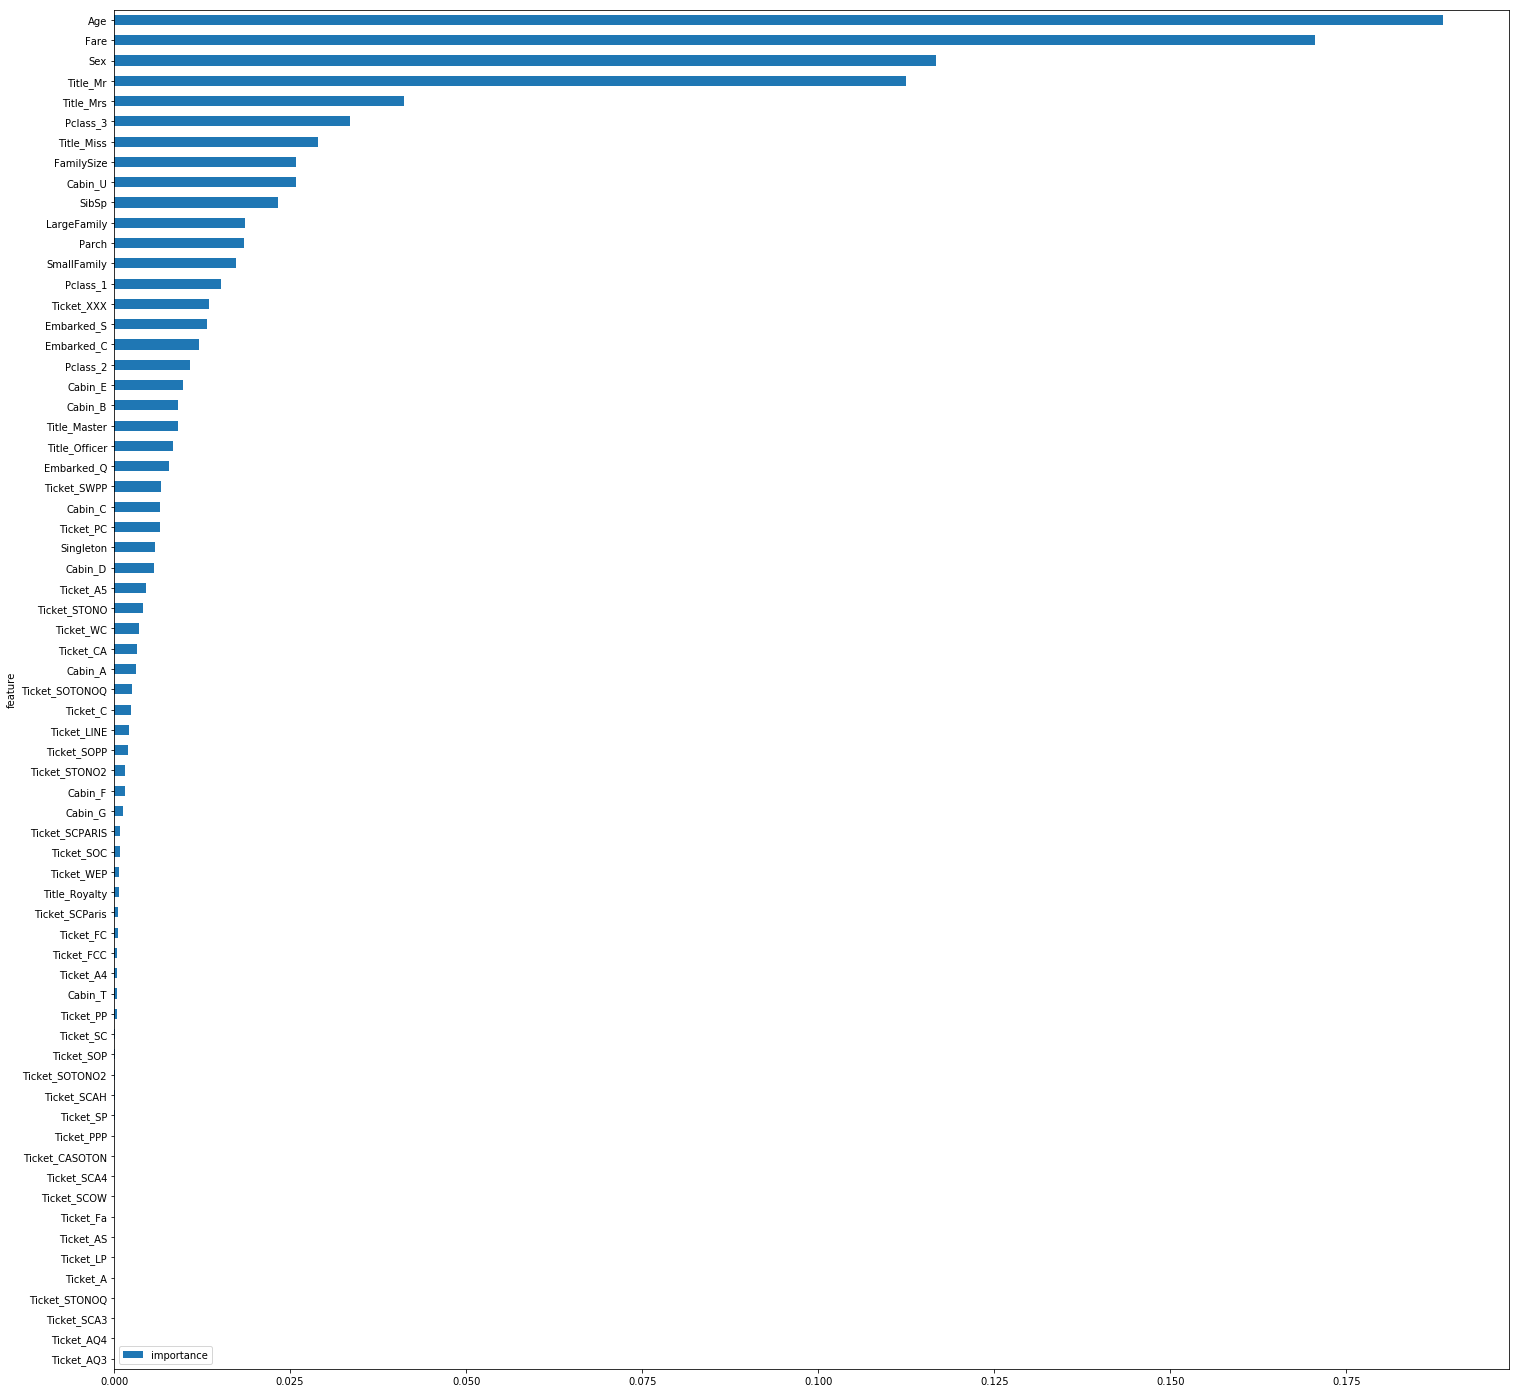

In [103]:
features.plot(kind='barh', figsize=(25, 25))


As you may notice, there is a great importance linked to Title_Mr, Age, Fare, and Sex.

There is also an important correlation with the Passenger_Id.

Let's now transform our train set and test set in a more compact datasets.



In [110]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)


(891, 14)


In [116]:
test = test.fillna(0)

test_reduced = model.transform(test)


In [117]:

print(test_reduced.shape)


(418, 14)


Yay! Now we're down to a lot less features.

We'll see if we'll use the reduced or the full version of the train set.



Let's try different base models¶


In [118]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]


In [122]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print ('CV score = {0}'.format(score))
    print ('****')


Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.8125769783320514
****
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.8226832735947787
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8170777083517301
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8249176976842577
****


Hyperparameters tuning
As mentioned in the beginning of the Modeling part, we will be using a Random Forest model. It may not be the best model for this task but we'll show how to tune. This work can be applied to different models.

Random Forest are quite handy. They do however come with some parameters to tweak in order to get an optimal model for the prediction task.

To learn more about Random Forests, you can refer to this link :

Additionally, we'll use the full train set.



# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)


Now that the model is built by scanning several combinations of the hyperparameters, we can generate an output file to submit on Kaggle.



In [125]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('gridsearch_rf.csv', index=False)


In [ ]:
[BONUS] Blending different models
I haven't personally uploaded a submission based on model blending but here's how you could do it



In [126]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']


In [127]:
predictions_df.to_csv('blending_base_models.csv', index=False)


IV - Conclusion
In this article, we explored an interesting dataset brought to us by Kaggle.

We went through the basic bricks of a data science pipeline:

Data exploration and visualization: an initial step to formulate hypotheses
Data cleaning
Feature engineering
Feature selection
Hyperparameters tuning
Submission
Blending
This post can be downloaded as a notebook if you ever want to test and play with it : my github repo

Lots of articles have been written about this challenge, so obviously there is a room for improvement.

Here is what I suggest for next steps:

Dig more in the data and eventually build new features.
Try different models : logistic regressions, Gradient Boosted trees, XGboost, ...
Try ensemble learning techniques (stacking)
Run auto-ML frameworks
I would be more than happy if you could find out a way to improve my solution. This could make me update the article and definitely give you credit for that. So feel free to post a comment.